# 05 — Walk-Forward Pair Results (Sharpe-Targeted)


In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
project_root = os.path.abspath("..")
sys.path.append(project_root)
from config import DATA_PATH, FEE_BPS, SLIPPAGE_BPS
from Data.raw_data_loader import load_raw_crypto_csv
from Models.ou import build_spread, ou_signal_on_spread
from Backtest.metrics import build_summary_table, rolling_sharpe
sns.set_theme(style="whitegrid")


In [2]:
def sharpe_ratio(r: pd.Series) -> float:
    r = r.dropna()
    if len(r) < 60 or r.std() == 0:
        return np.nan
    return float(np.sqrt(365) * r.mean() / r.std())

def pair_returns(df: pd.DataFrame, position: pd.Series, beta_window: int, orientation: int) -> pd.Series:
    log_b = np.log(df["BTC-USD_close"].astype(float))
    log_e = np.log(df["ETH-USD_close"].astype(float))
    minp = min(beta_window, max(30, beta_window // 3))
    beta = (log_b.rolling(beta_window, min_periods=minp).cov(log_e) / log_e.rolling(beta_window, min_periods=minp).var()).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    r_btc = df["BTC-USD_close"].astype(float).pct_change().fillna(0.0)
    r_eth = df["ETH-USD_close"].astype(float).pct_change().fillna(0.0)
    pos = position.reindex(df.index).fillna(0.0)
    gross = pos * (r_eth - beta * r_btc)
    if int(orientation) == -1:
        gross = -gross
    turnover = pos.diff().abs().fillna(0.0)
    return gross - turnover * (FEE_BPS + SLIPPAGE_BPS) / 1e4

def walk_forward_splits(index, train_days=730, test_days=180, step_days=180):
    t0 = index.min(); t1 = t0 + pd.Timedelta(days=train_days); end = index.max()
    while True:
        te0 = t1 + pd.Timedelta(days=1); te1 = te0 + pd.Timedelta(days=test_days)
        if te1 > end: break
        yield (t0, t1, te0, te1)
        t1 = t1 + pd.Timedelta(days=step_days)


In [3]:
df = load_raw_crypto_csv(DATA_PATH).loc["2017-11-12":].copy()
mask = (df["BTC-USD_close"] > 0) & (df["ETH-USD_close"] > 0)
mask &= (df["BTC-USD_close"].pct_change().abs() < 1.0)
mask &= (df["ETH-USD_close"].pct_change().abs() < 1.0)
df = df.loc[mask].copy()
param_grid = {"beta_window": [60, 90, 120, 180], "ou_window": [30, 45, 60, 90], "entry_z": [1.0, 1.25, 1.5, 1.75], "exit_z": [0.1, 0.2, 0.3, 0.5]}
splits = list(walk_forward_splits(df.index, train_days=365 * 2, test_days=180, step_days=180))
print("Folds:", len(splits))


Folds: 12


In [4]:
rows = []
all_test_net = pd.Series(0.0, index=df.index)
all_test_pos = pd.Series(0.0, index=df.index)
for fold, (tr0, tr1, te0, te1) in enumerate(splits, 1):
    train_df = df.loc[tr0:tr1].copy(); test_df = df.loc[te0:te1].copy(); best = None
    for bw in param_grid["beta_window"]:
        spread_tr = build_spread(train_df, beta_window=bw)
        for ow in param_grid["ou_window"]:
            for ent in param_grid["entry_z"]:
                for ex in param_grid["exit_z"]:
                    if ex >= ent: continue
                    pos_tr = ou_signal_on_spread(spread_tr, window=ow, entry_z=ent, exit_z=ex, long_short=True)
                    s_p = sharpe_ratio(pair_returns(train_df, pos_tr, beta_window=bw, orientation=1))
                    s_m = sharpe_ratio(pair_returns(train_df, pos_tr, beta_window=bw, orientation=-1))
                    s, o = (s_p, 1) if np.nan_to_num(s_p, nan=-9) >= np.nan_to_num(s_m, nan=-9) else (s_m, -1)
                    if not np.isfinite(s): continue
                    if (best is None) or (s > best["train_sharpe"]):
                        best = {"beta_window": bw, "ou_window": ow, "entry_z": ent, "exit_z": ex, "orientation": o, "train_sharpe": s}
    spread_te = build_spread(test_df, beta_window=best["beta_window"])
    pos_te = ou_signal_on_spread(spread_te, window=best["ou_window"], entry_z=best["entry_z"], exit_z=best["exit_z"], long_short=True)
    net_te = pair_returns(test_df, pos_te, beta_window=best["beta_window"], orientation=best["orientation"])
    all_test_net.loc[net_te.index] = net_te; all_test_pos.loc[pos_te.index] = pos_te
    rows.append({"fold": fold, "train_start": tr0, "train_end": tr1, "test_start": te0, "test_end": te1, **best, "test_sharpe": sharpe_ratio(net_te)})
wf_table = pd.DataFrame(rows)
wf_table


,fold,train_start,train_end,test_start,test_end,beta_window,ou_window,entry_z,exit_z,orientation,train_sharpe,test_sharpe
0,1,2017-11-13,2019-11-13,2019-11-14,2020-05-12,180,45,1.75,0.1,1,1.565431,1.726279
1,2,2017-11-13,2020-05-11,2020-05-12,2020-11-08,180,60,1.00,0.1,1,1.854211,1.407917
2,3,2017-11-13,2020-11-07,2020-11-08,2021-05-07,180,60,1.00,0.1,1,1.686782,3.257687
3,4,2017-11-13,2021-05-06,2021-05-07,2021-11-03,180,60,1.00,0.1,1,1.398637,-0.097495
4,5,2017-11-13,2021-11-02,2021-11-03,2022-05-02,180,30,1.00,0.1,1,1.242082,-1.041380
5,6,2017-11-13,2022-05-01,2022-05-02,2022-10-29,180,30,1.00,0.1,1,1.193229,2.764023
6,7,2017-11-13,2022-10-28,2022-10-29,2023-04-27,180,30,1.00,0.1,1,1.308042,-0.484485
7,8,2017-11-13,2023-04-26,2023-04-27,2023-10-24,180,30,1.00,0.1,1,1.241570,0.670734
8,9,2017-11-13,2023-10-23,2023-10-24,2024-04-21,180,30,1.00,0.1,1,1.204653,0.149056
9,10,2017-11-13,2024-04-20,2024-04-21,2024-10-18,180,30,1.00,0.1,1,1.176572,0.379289


In [5]:
summary = build_summary_table({"WalkForward OU Pair": {"returns": all_test_net.fillna(0.0), "position": all_test_pos.fillna(0.0)}})
summary


,Sharpe,Sortino,CAGR,MaxDD,Calmar,AnnualReturn,AnnualVol,Observations,AnnualTurnover
Strategy,,,,,,,,,
WalkForward OU Pair,0.545017,0.492496,0.129049,-0.572678,0.225343,0.169561,0.311112,3008,6.552527


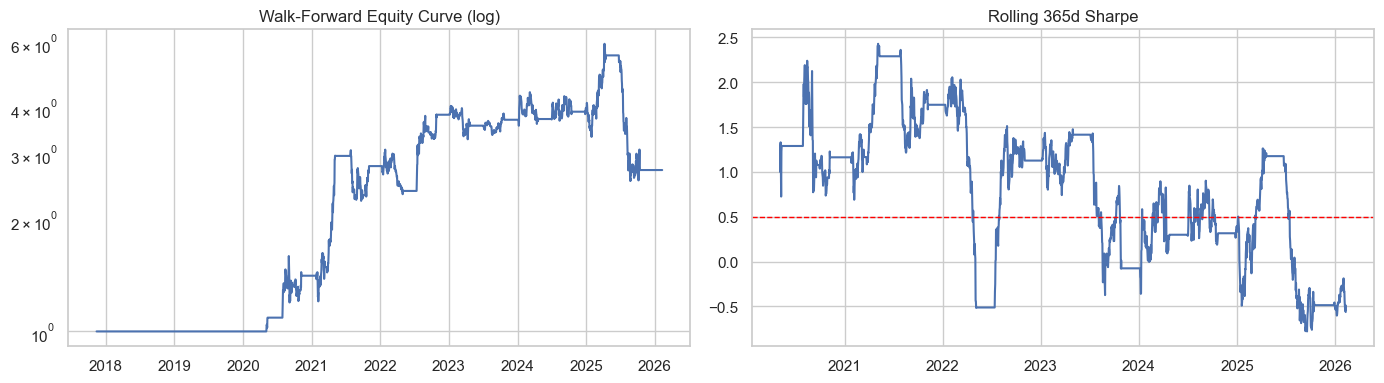

In [6]:
wf_equity = (1 + all_test_net.fillna(0.0)).cumprod()
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(wf_equity.index, wf_equity.values); ax[0].set_yscale("log"); ax[0].set_title("Walk-Forward Equity Curve (log)")
ax[1].plot(rolling_sharpe(all_test_net.fillna(0.0), window=365)); ax[1].axhline(0.5, color="red", linestyle="--", linewidth=1); ax[1].set_title("Rolling 365d Sharpe")
plt.tight_layout(); plt.show()


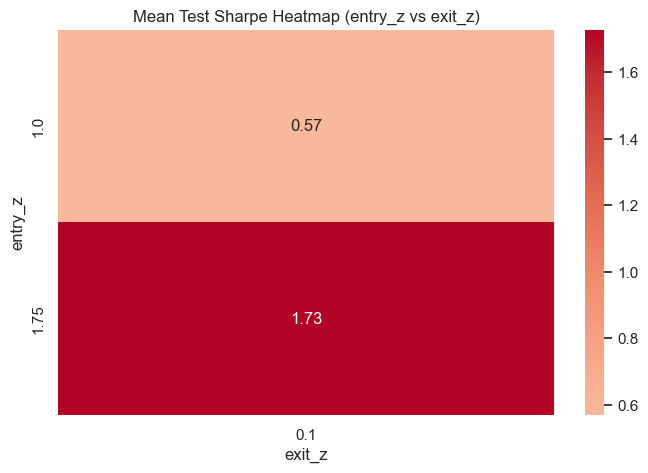

In [7]:
pivot = wf_table.pivot_table(index="entry_z", columns="exit_z", values="test_sharpe", aggfunc="mean")
plt.figure(figsize=(8, 5)); sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Mean Test Sharpe Heatmap (entry_z vs exit_z)")
plt.show()
